# SARIMA Forecast

## 01 - Background

Our goal in this challenge is to apply the basic concepts of time series analysis to one-dimensional data (sales depending on the date).

In this challenge, we'll go through the following steps:
1. load and visualize the data;
2. train our models and make predictions;
3. use an econometric approach to model the series and be able to forecast it;
4. use Machine Learning to hack this model.

The dataset is courtesy of [Machine Learning Mastery](https://github.com/jbrownlee/). Run the line below to download it!

In [ ]:
!curl https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly_champagne_sales.csv > data/monthly_champagne_sales.csv

## 02 - Load Data
Let's start by loading the time series of the challenge

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/monthly_champagne_sales.csv")
df.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


👉 Convert the DataFrame's "Month" column to `Datetime` objects, and set it as the index to make it look like this:
<br>

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/05-ML/09-Time-Series/monthly_champagne_sales_objective.png" width=180>

In [2]:
import datetime
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946
...,...
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298


### Alternative - Let Pandas do the Work

In [3]:
# We can also use pandas magic to handle the conversions from the start
df = pd.read_csv("data/monthly_champagne_sales.csv", parse_dates=['Month'], index_col='Month')
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


## 04 - Visualize and Interpret the Data

Well done, thanks to this re-indexing, you should now be able to plot the "Sales" (y-axis) as a function of the time (x-axis) easily

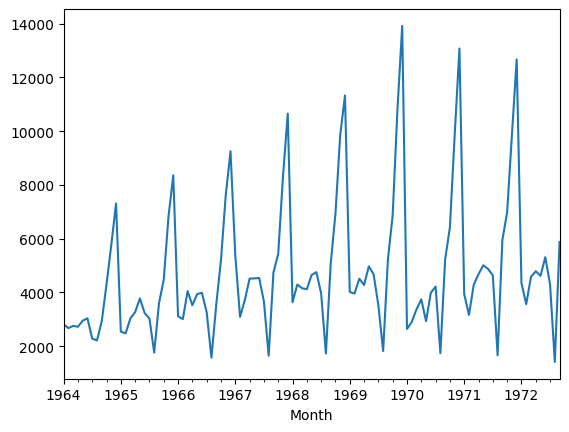

In [4]:
df["Sales"].plot();

If your code is correct, you should be able to see that this time series (TS) is:
- Not stationary (mean and variance are not constant).
- Exhibits strong seasonality.
- Seems to have a trend.

Let's see a decomposition of the data between **trend**, **seasonality** and **noise**. To do that, you have to make use of statsmodels' [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). Read the docs and make sure you understand what this function is doing and how to use it, then:
1. Plot the "Sales" with an "additive" model
2. Plot the "Sales" with a "multiplicative" model

Pro tips: end your statsmodels plot method calls with a semicolon (`;`) to avoid double-plotting issues!

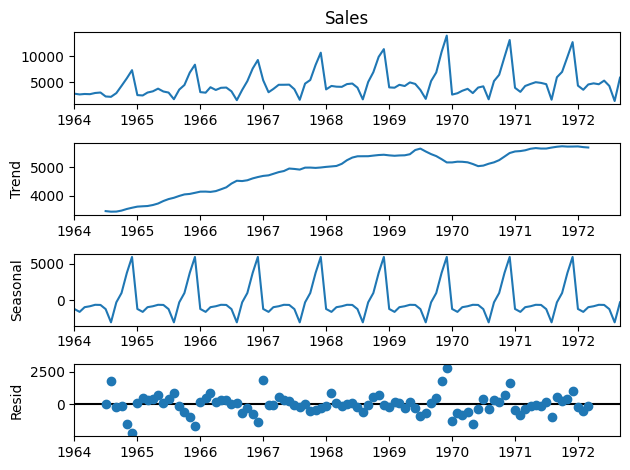

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(df['Sales'], model='additive')
result_add.plot();

👉 De-seasonalize this time series using the decomposition of your choice

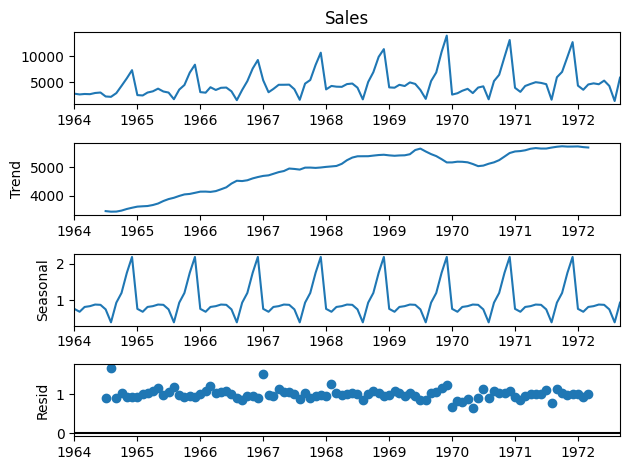

In [6]:
result_mul = seasonal_decompose(df['Sales'], model='multiplicative')
result_mul.plot();

☝️ We could fit an ARIMA model on a "deseasonalized" version of this time series, and then re-compose it after our forecast. But in this challenge, we will use SARIMA models to _directly_ fit the original time series!

## 05 - Split the Data (train/test)


For time series, we cannot randomly sample points to be in the test set. The test set needs to be "out-of-time", that is, strictly in the future of the test set. For this exercise, we will use data up to 1970 for training, and anything after that will be used for the test.

👉 create `df_train` and `df_test`, splitting the DataFrame before 1970 for the training and after (or equal to) for the testing

In [7]:
df_train = df[df.index.year < 1970]
df_test = df[df.index.year >= 1970]

## 06 - SARIMA
We will analyze the data using a SARIMA model (Seasonal Auto-Regressive Integrated Moving Average).


We need to :
- find how to stationarize the time series (I in SARIMA)
- find the auto-regressive (AR) part
- find the moving average (MA) part
- find the seasonality (S)

### Step 1: Check Stationarity

If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast.

A glance at the plot above should be sufficient to convince you that the time series is not stationary.

Double check the stationarity of `df["Sales"]` using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) and especially its p-value

In [8]:
from statsmodels.tsa.stattools import adfuller

adfuller(df['Sales'])[1]

0.36391577166024813

The p-value should be less than 0.05 to have a 95% confidence in the stationarity.  

If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

Ideally, p is *much* smaller than 0.05.

Another way to look for stationarity is to look at the autocorrelation function (ACF).

Plot the ACF of the time series. You should see a large peak at lag 12, indicating strong yearly seasonality.

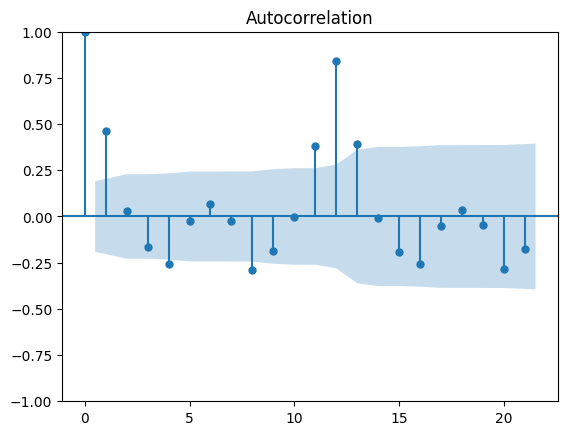

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['Sales'])
plt.show()

### Step 2 - Seasonal Differencing (D)

We have a strong seasonality with a period of 12 months.

Do a **seasonal differencing of lag 12** on the time series, plot the differenced data, and check the ACF plot (+ADF test) again.

Don't forget to drop NaN's.

In [10]:
seasonal_diff_1 = df['Sales'].diff(12).dropna()
seasonal_diff_2 = df['Sales'].diff(24).dropna()

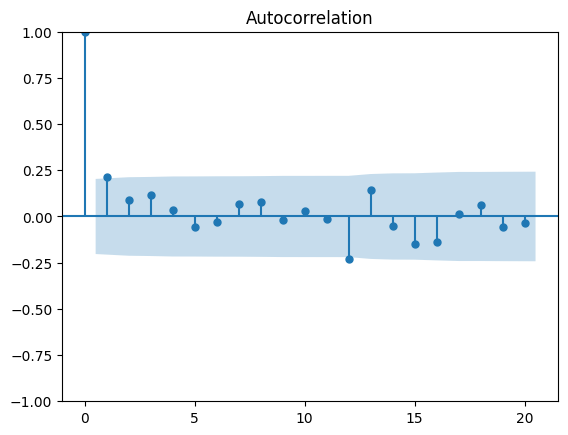

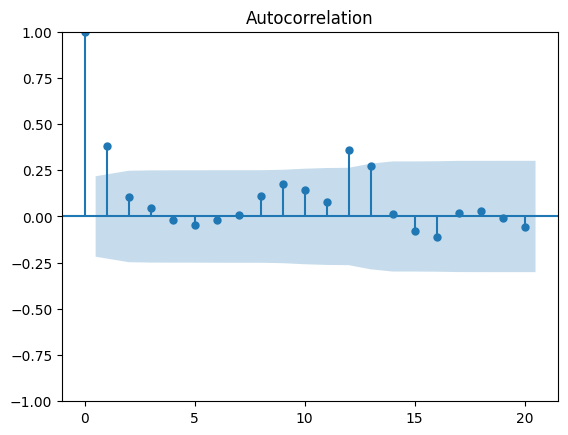

In [11]:
plot_acf(seasonal_diff_1)
plot_acf(seasonal_diff_2);

In [12]:
print(adfuller(seasonal_diff_1)[1])
print(adfuller(seasonal_diff_2)[1])

2.060579696813685e-11
2.5614071575123544e-07


☝️ One single seasonal differencing seems enough to stationarize the TS.  
D=1 (1 seasonal diff) and m=12 (seasonality = 12) for SARIMA(p,d,q, P,D,Q,m)

### Step 3 - Differencing (d)

If the time series is still not stationary, it needs to be stationarized through *differencing*. It means that we take the difference between each value and the preceding one (*first difference*).

Do we need further differencing after removing the seasonality?

Check the ACF and ADF after running an additional first-order diff(1) on your diff(12) series.

In [13]:
seasonal_and_normal_diff_1 = seasonal_diff_1.diff(1).dropna()
seasonal_and_normal_diff_2 = seasonal_diff_1.diff(2).dropna()

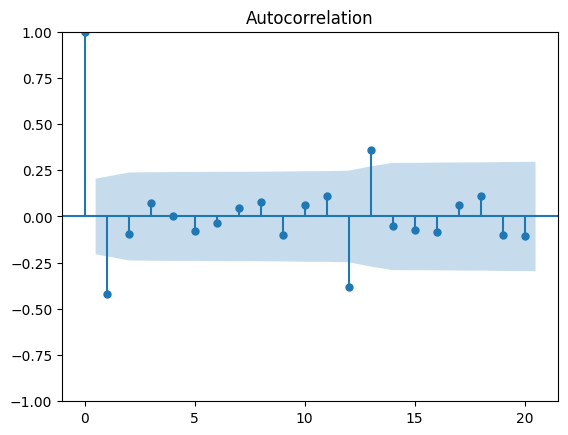

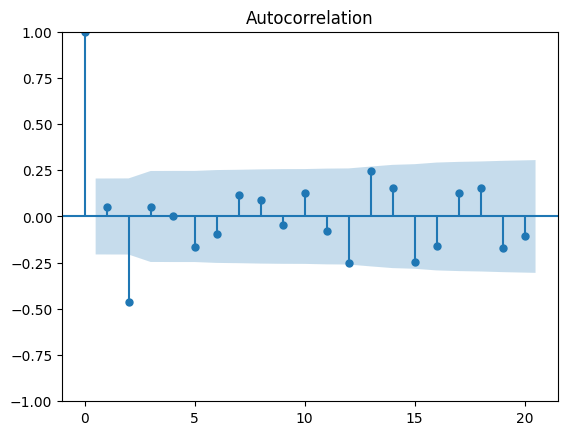

In [14]:
plot_acf(seasonal_and_normal_diff_1)
plot_acf(seasonal_and_normal_diff_2);

In [15]:
print(adfuller(seasonal_and_normal_diff_1)[1])
print(adfuller(seasonal_and_normal_diff_2)[1])

0.00026504628492935025
1.1143574378831865e-08


👉 Additional differencing made both the p-value and the ACF look worse! 
We can select (d=0) and (D=1)

### Step 4 - Select AR(p, P) and MA(q, Q) Terms

You will now use the ACF and PACF plots to decide whether to include an AR term(s), MA term(s), or both.

- The autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to your **fully differentiated** series allows you to select an MA number (`q`)
- MA($\color{blue}{q}$) = number of lags beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d+D)}}$ cuts off


- The partial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to your **fully differentiated** series allows you to select AR (`p`)
- AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d+D)}}$  cuts off

/Users/florencetersier/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


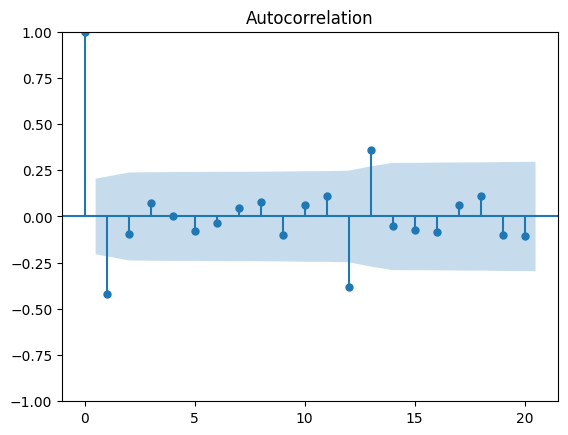

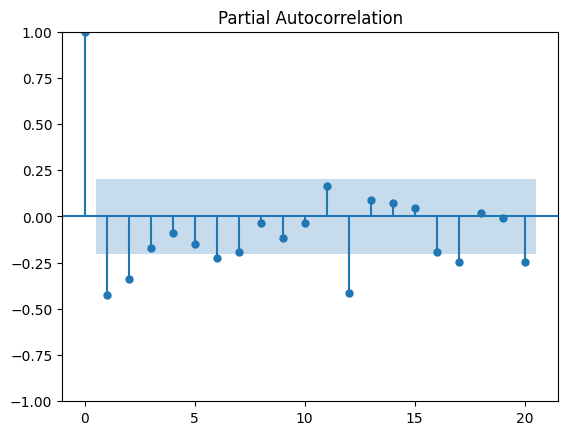

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(seasonal_and_normal_diff_1)
plot_pacf(seasonal_and_normal_diff_1);

☝️ It seems like there are no significant peaks in either ACF or PACF, so most likely p=q=0.  
Our first guess for SARIMA is therefore d=0, p=q=0, D=1 and m=12.  

How to find values for P and Q? Here, we will let `pdarima` try values 1 and 0 for P and Q with a grid_search for us.
If you want to find these coefficients by yourself, [read this 🤯 ](https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima) for some rules of thumb

👉 Run [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) for the training set. Set seasonal=True, m=12 and D=1. Search for p and q, P and Q from 0 to 2. Then, print the summary of the model with model.summary().
Use `njobs=-1, trace=True, error_action='ignore', suppress_warnings=True`

In [17]:
import pmdarima as pm
from pmdarima.arima import auto_arima
smodel = pm.auto_arima(df_train, seasonal=True, m=12, D=1,
                       start_p=0, max_p=2, start_q=0, max_q=2,
                       start_P=0, max_P=2, start_Q=0, max_Q=2, 
                       n_jobs=-1,
                       trace=True, error_action='ignore', suppress_warnings=True)

/Users/florencetersier/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=954.252, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=957.794, Time=0.08 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=957.973, Time=0.03 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=974.624, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=956.000, Time=0.02 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=955.904, Time=0.05 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=957.929, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=956.182, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=956.250, Time=0.01 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=958.187, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 0.311 seconds


The best model found is `ARIMA(0,0,0)(0,1,0)[12]`!
This means that the time series considered does not justify adding any "auto-regressive" or "moving average" modelling beyond simple "seasonal differencing".

Such a "poor" model is only likely to predict a repetition of the last seasonal pattern detected, along with the prolongation of the mean increasing trend. Let's check it out

👉 Use `model.predict` with `n_periods` = length of the test set to save the following three predictions
- `central`
- `upper`
- `lower`

Save them as a Pandas Series, and index them by the same index as your `y_test`

In [26]:
y_test = pd.DataFrame(smodel.predict(len(df_test), alpha=0.5))
y_test

,0
1970-01-01,4463.05
1970-02-01,4404.05
1970-03-01,4957.05
1970-04-01,4723.05
1970-05-01,5415.05
1970-06-01,5124.05
1970-07-01,3970.05
1970-08-01,2268.05
1970-09-01,5669.05
1970-10-01,7319.05


👇 Run the cell below to plot your predictions against reality

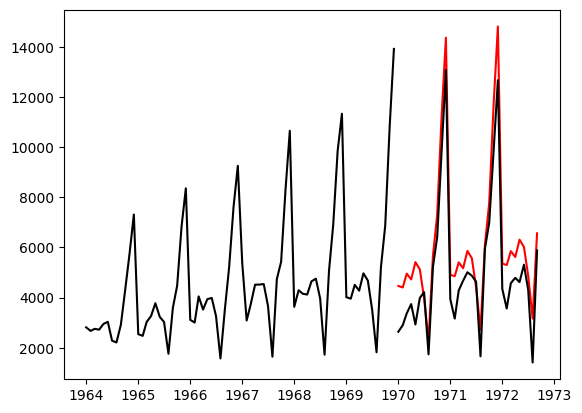

In [27]:
plt.plot(df_train, c='black')
plt.plot(y_test, c='red')
plt.plot(df_test, c='black')

👉 Try to assign non-null values to `p`, `d`, `P`, `D` on your SARIMA and re-plot this chart to compare effects!

# OPTIONAL - Machine Learning Approach

### Model with a forecast horizon = 1 month only

We will now fit a non-linear model such as a Random Forest. The idea is to predict a value from the last ones. 

👉 Create new columns in `df` that are a shifted version of `df['Sales']`. Do it with a shift from 1 to 12.

In [ ]:
# YOUR CODE HERE

👉 Instantiate (don't train) a `random forest` algorithm to predict Sales based on your shifted features

In [ ]:
# YOUR CODE HERE

👉 You can use the following function to test it. It takes the true y values (`data` which should be a NumPy array), the indexes of the test samples (`test_indexes`), the predictor (`predictor`: your random forest algorithm), and the shifted columns (`full_X` which should be a NumPy array).

In [ ]:
# For each predictor, design a method to evaluate its performance on the test set:
from sklearn.metrics import r2_score

def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0

    for _index in test_indexes:
        train_data = y_true[:_index]
        current_ground_truth = y_true[_index]
        current_ground_truth_features = full_X[_index,:]
        train_features = full_X[:_index]

        # train the model on all data points until (t-1) to predict (t)
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)

        i += 1

    mape = np.mean(np.abs(np.array(predictions) - np.array(ground_truth))/np.abs(np.array(ground_truth)))

    return ground_truth, predictions, mape

In [ ]:
# YOUR CODE HERE

To improve our model, we can do some feature engineering. You will add moving averages to the data used to train the random forest.

Try to create 3 new columns in `df`: one which is the rolling average of `df[Sales]` with a window of 12, one with a window of 3, and one with a window of 2. This will have the effect of isolating the trend and allowing the algorithm to learn it. Plot these data.


In [ ]:
# YOUR CODE HERE

You can also add a stronger smoothing predictor using the exponential moving average (hint: method `.ewm` with a `halflife` of 2, 3, and 12), which statistically optimizes an AR process. Plot these data.

In [ ]:
# YOUR CODE HERE

You should see a better MAPE!

Try to look at the importance of each feature. What do you find?


In [ ]:
# YOUR CODE HERE

### Out-of-Sample Forecast Models

Let's now try to beat SARIMA in the "out-of-sample" prediction. 

👉 Train _one model per horizon of forecast_ (from `1`-month horizon to `len(y_test)` months)  
👉 Evaluate MAPE and compare with SARIMA